## The sole objective of this code is to create anomaly detection model

### Dataset Description

* The dataset contains data on the water quality for the Southern Bug (or Pivdennyi Booh) River.

* There are 22 stations of the state water monitoring system.

* Data are monthly or quarterly. The number of observations on stations is different (from some to more than 20 years).






### EDA

In [1]:
import pandas as pd

df = pd.read_csv("Data/PB_All_2000_2021.csv", sep=';')
df.head()

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,17.02.2000,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5
1,1,11.05.2000,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0
2,1,11.09.2000,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0
3,1,13.12.2000,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0
4,1,02.03.2001,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0


In [2]:
df.shape

(2861, 11)

<Figure size 1200x1200 with 0 Axes>

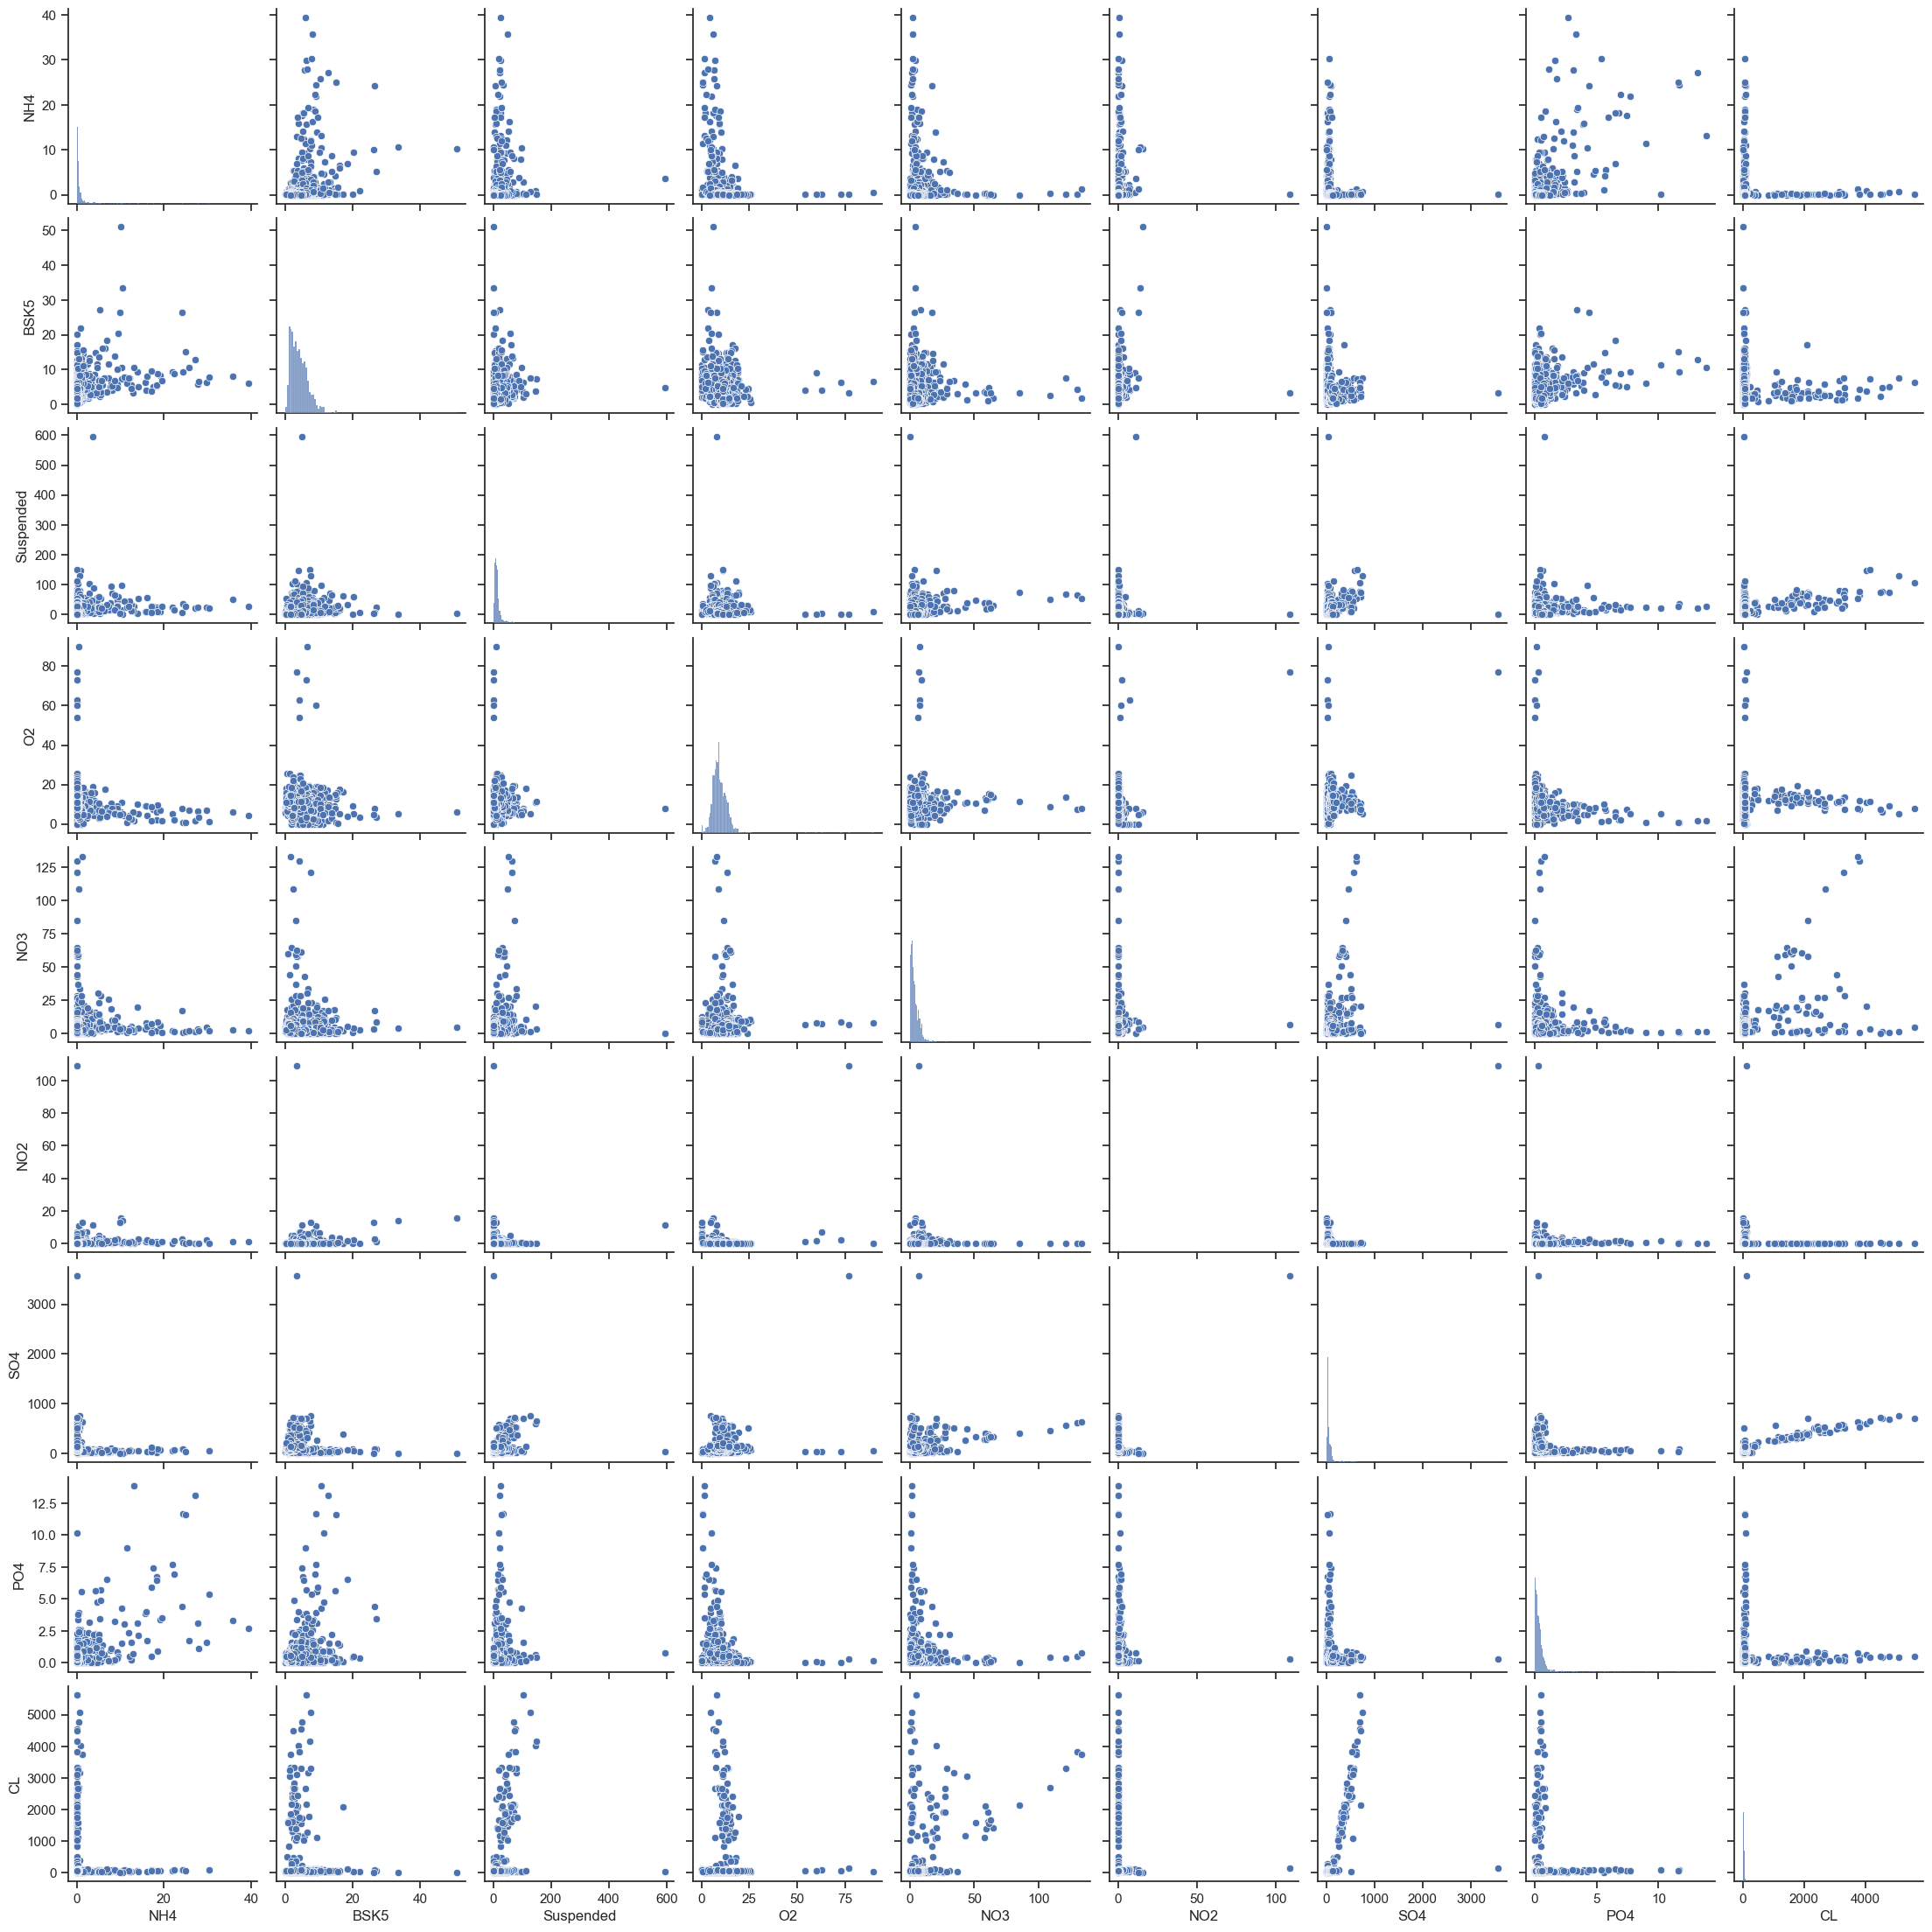

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("Data/PB_All_2000_2021.csv", sep=';')  # Replace with your actual file path

# Convert 'date' column to datetime if necessary
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')


# Select only numerical columns for plotting (excluding 'id' and 'date')
df_numerical = df.select_dtypes(include=['float64', 'int64']).drop(['id'], axis=1)

# Plot scatter matrix
sns.set(style="ticks")
plt.figure(figsize=(12, 12))
scatter_matrix = sns.pairplot(df_numerical)
plt.show()

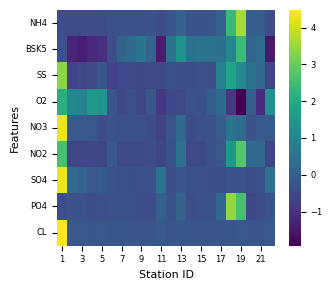

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your DataFrame
df = pd.read_csv("Data/PB_All_2000_2021.csv", sep=';')  # Replace with your actual file path

# Group data by 'id' and compute the mean for each station
df_grouped = df.groupby('id').mean(numeric_only=True).reset_index()  # Only keep numeric columns

# Set 'id' as index for heatmap visualization
df_heatmap = df_grouped.set_index('id')

# Rename the feature 'Suspended' to 'SS'
df_heatmap = df_heatmap.rename(columns={'Suspended': 'SS'})

# Normalize the data using Pandas directly
df_normalized = (df_heatmap - df_heatmap.mean()) / df_heatmap.std()

# Plotting the heatmap
plt.figure(figsize=(3.5, 3))  # Smaller figure size suitable for double-column paper
heatmap = sns.heatmap(df_normalized.T, cmap="viridis", annot=False, cbar=True)

# Customize font sizes for x and y axis labels, ticks, and colorbar
#plt.title('Heatmap of Normalized Features', fontsize=10)
plt.xlabel('Station ID', fontsize=8)
plt.ylabel('Features', fontsize=8)

# Increase font size for ticks
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

# Customize colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=6)  # Font size for colorbar ticks

plt.tight_layout()  # Ensure everything fits well
plt.savefig('hm.png', dpi=300)  # Save with high resolution for better quality in papers
plt.show()

### End of EDA

we conclude that 1 is upstream and 22 is downstream

### Anamoly labeling with GMM

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv("Data/PB_All_2000_2021.csv", delimiter=';')

# Preprocessing: Check for missing data and remove rows with NaN values
nan_count = df.isna().sum()
total_nan = df.isna().sum().sum()

# Print NaN details
print("NaN values per column:")
print(nan_count)
print(f"Total number of NaN values in the dataset: {total_nan}")

# Remove rows with NaN values
df_cleaned = df.dropna()

# Separate 'id' column from the rest of the numerical data
id_column = df_cleaned['id']
df_numeric_cleaned = df_cleaned.select_dtypes(include=[np.number]).drop(columns=['id'])

# Standardize the data (excluding the 'id' column)
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df_numeric_cleaned)

# Convert the standardized data back to a DataFrame and use the original column names
df_scaled_cleaned = pd.DataFrame(df_scaled_array, columns=df_numeric_cleaned.columns)

# Add the 'id' column back to the scaled DataFrame
df_scaled_cleaned.insert(0, 'id', id_column.values)

# Save preprocessed data to use in the next cell
df_scaled_cleaned.head()

NaN values per column:
id            0
date          0
NH4           3
BSK5          1
Suspended    16
O2            3
NO3           1
NO2           3
SO4          49
PO4          28
CL           49
dtype: int64
Total number of NaN values in the dataset: 153


,id,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,-0.166153,-0.535664,-0.053124,0.616559,0.740373,-0.077557,0.970836,0.094530,0.491277
1,1,-0.322451,-0.452299,2.324045,1.135155,1.926234,-0.088211,3.009529,-0.473395,4.276621
2,1,-0.329009,-0.778510,0.697245,0.071023,1.358458,-0.023826,3.668501,-0.301769,6.083004
3,1,-0.253592,-0.731390,1.363573,0.639009,1.837115,-0.058103,2.218763,-0.025608,2.946397
4,1,-0.346496,-0.441425,2.155963,1.153115,0.812243,-0.073851,2.284661,-0.404745,3.445231


In [41]:
from sklearn.mixture import GaussianMixture

# Extract the 'id' column
id_column = df_scaled_cleaned['id']

# Remove the 'id' column before fitting GMM
df_for_gmm = df_scaled_cleaned.drop(columns=['id'])

# Fit a Gaussian Mixture Model
n_components = 2  # Number of clusters, can be tuned
model = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
model.fit(df_for_gmm)

# Compute the log-likelihood of each data point
log_likelihood = model.score_samples(df_for_gmm)

# Set threshold for anomaly detection
threshold = np.percentile(log_likelihood, 5)  # Marking bottom 5% as anomalies

# Assign labels
labels = np.where(log_likelihood < threshold, 1, 0)  # 1 indicates anomaly, 0 indicates normal

# Add the 'id' column and the labels back to the DataFrame
df_labeled_cleaned = df_for_gmm.copy()
df_labeled_cleaned['id'] = id_column.values
df_labeled_cleaned['Anomaly'] = labels

df_labeled_cleaned.head()

,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,id,Anomaly
0,-0.166153,-0.535664,-0.053124,0.616559,0.740373,-0.077557,0.970836,0.094530,0.491277,1,0
1,-0.322451,-0.452299,2.324045,1.135155,1.926234,-0.088211,3.009529,-0.473395,4.276621,1,0
2,-0.329009,-0.778510,0.697245,0.071023,1.358458,-0.023826,3.668501,-0.301769,6.083004,1,1
3,-0.253592,-0.731390,1.363573,0.639009,1.837115,-0.058103,2.218763,-0.025608,2.946397,1,0
4,-0.346496,-0.441425,2.155963,1.153115,0.812243,-0.073851,2.284661,-0.404745,3.445231,1,0


In [42]:
# Count how many data points are labeled as anomalies and normal
anomaly_counts = df_labeled_cleaned['Anomaly'].value_counts()

# Print the results
print("Anomaly counts:")
print(anomaly_counts)

Anomaly counts:
Anomaly
0    2637
1     139
Name: count, dtype: int64


#### AIC and BIC for checking if we got the appropriate number of GMMs

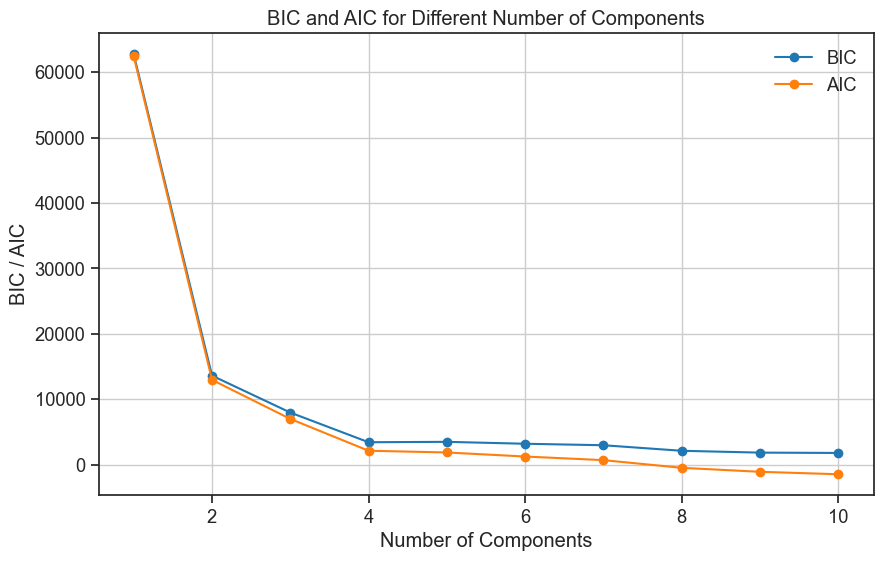

Optimal number of components based on BIC: 10
Optimal number of components based on AIC: 10


In [94]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Extract the 'id' column
df_for_gmm = df_scaled_cleaned.drop(columns=['id'])

# Range of components to test (from 1 to 10, you can adjust the range)
component_range = range(1, 11)

# Lists to store BIC and AIC values
bic_values = []
aic_values = []

# Loop over different number of components
for n_components in component_range:
    model = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    model.fit(df_for_gmm)
    
    # Compute BIC and AIC
    bic_values.append(model.bic(df_for_gmm))
    aic_values.append(model.aic(df_for_gmm))

# Visualizing BIC and AIC to find the elbow
plt.figure(figsize=(10, 6))

# Plot BIC and AIC
plt.plot(component_range, bic_values, label='BIC', marker='o')
plt.plot(component_range, aic_values, label='AIC', marker='o')

# Add labels and title
plt.xlabel('Number of Components')
plt.ylabel('BIC / AIC')
plt.title('BIC and AIC for Different Number of Components')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Identify the optimal number of components based on BIC and AIC
optimal_bic_components = component_range[np.argmin(bic_values)]
optimal_aic_components = component_range[np.argmin(aic_values)]

print(f"Optimal number of components based on BIC: {optimal_bic_components}")
print(f"Optimal number of components based on AIC: {optimal_aic_components}")

here the ideal number of gaussians is 2, after 2 the returns are diminishing! so we proceed with visualization

/Users/qusai/Desktop/NCR/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


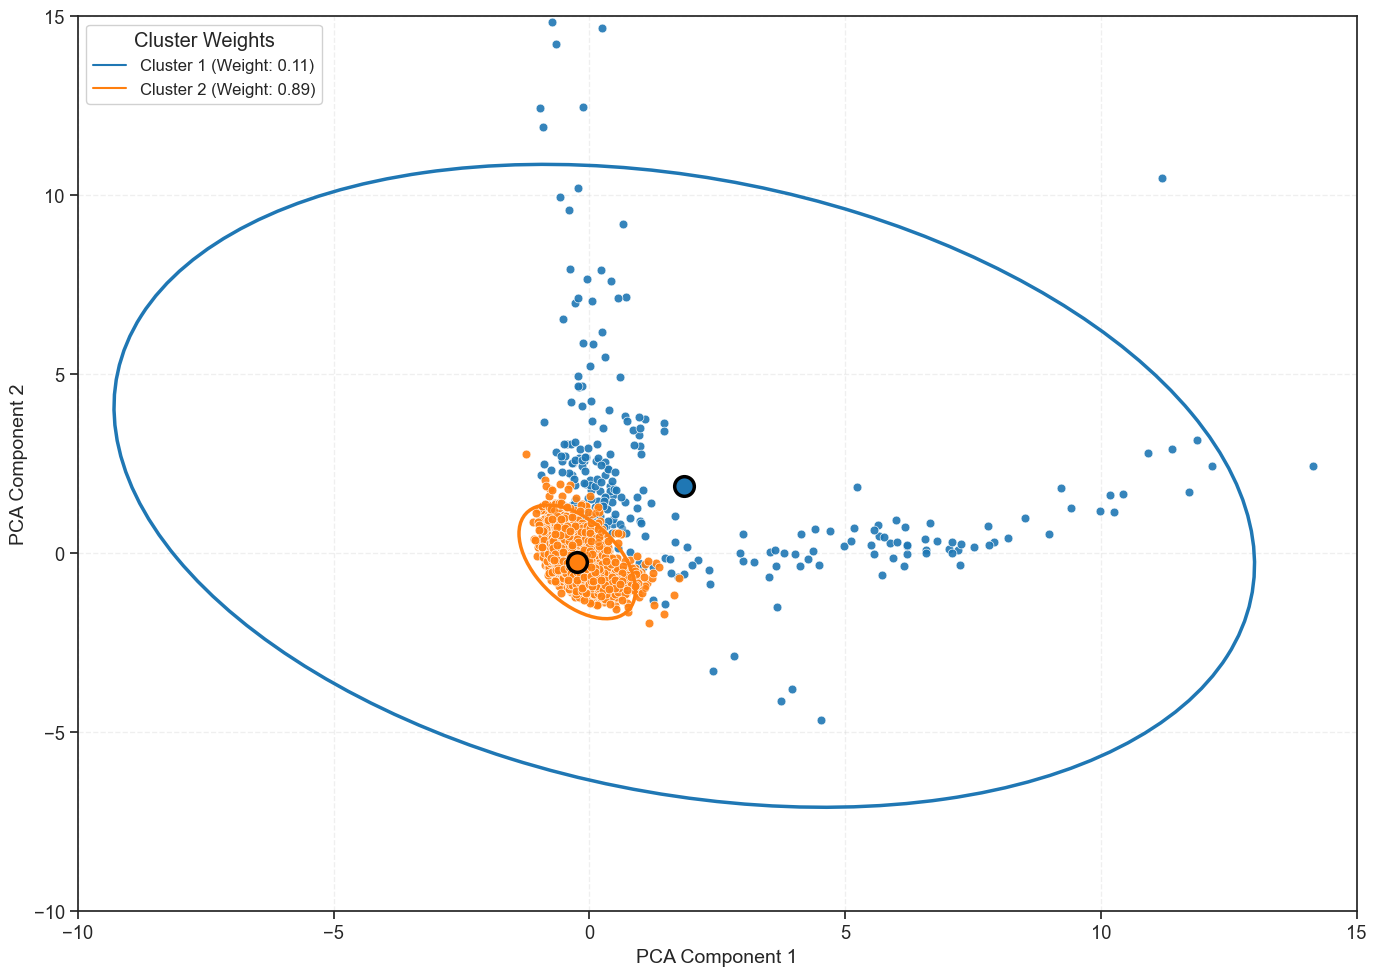

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-white')
sns.set_context("notebook", font_scale=1.2)

# Remove 'id' column before fitting the model
df_for_gmm = df_scaled_cleaned.drop(columns=['id'])

# Fit the Gaussian Mixture Model (use your actual number of components)
n_components = 2  # Adjusted based on your findings
model = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
model.fit(df_for_gmm)

# Get cluster assignments and probabilities
labels = model.predict(df_for_gmm)
probs = model.predict_proba(df_for_gmm)

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
df_for_gmm_2d = pca.fit_transform(df_for_gmm)
means_2d = pca.transform(model.means_)

# Transform covariances to 2D
covariances_2d = []
for i in range(n_components):
    cov = model.covariances_[i]
    cov_2d = pca.components_.dot(cov).dot(pca.components_.T)
    covariances_2d.append(cov_2d[:2, :2])

# Create a distinctive and colorblind-friendly colormap
colors = sns.color_palette("tab10", n_components)

# Create figure with single plot
fig = plt.figure(figsize=(14, 10))
ax = plt.subplot(111)

# Calculate highest probability for coloring points
max_probs = np.max(probs, axis=1)

# Create a colorful scatter plot with cluster separation techniques
for i in range(n_components):
    high_prob_idx = (labels == i) & (max_probs > 0.7)
    medium_prob_idx = (labels == i) & (max_probs <= 0.7) & (max_probs > 0.4)
    low_prob_idx = (labels == i) & (max_probs <= 0.4)
    
    ax.scatter(df_for_gmm_2d[high_prob_idx, 0], df_for_gmm_2d[high_prob_idx, 1], 
               c=[colors[i]], s=40, alpha=0.9, edgecolor='w', linewidth=0.5)
    ax.scatter(df_for_gmm_2d[medium_prob_idx, 0], df_for_gmm_2d[medium_prob_idx, 1], 
               c=[colors[i]], s=30, alpha=0.6, edgecolor='w', linewidth=0.3)
    ax.scatter(df_for_gmm_2d[low_prob_idx, 0], df_for_gmm_2d[low_prob_idx, 1], 
               c=[colors[i]], s=20, alpha=0.3, edgecolor='none')

# Plot ellipses for each Gaussian component
for i in range(n_components):
    v, w = np.linalg.eigh(covariances_2d[i])
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    
    ell = Ellipse(xy=means_2d[i], width=v[0]*2, height=v[1]*2, 
                  angle=angle, facecolor='none', edgecolor=colors[i], 
                  linewidth=2.5, linestyle='-', zorder=10)
    ax.add_patch(ell)
    
    ax.scatter(means_2d[i, 0], means_2d[i, 1], c=[colors[i]], s=200, 
               edgecolor='black', marker='o', linewidth=2.5, zorder=20)

# Auto-adjust axis limits to focus on the data
ax.set_xlim(-10, 15)
ax.set_ylim(-10, 15)

# Add labels and title
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)

# Add custom legend with cluster weights
legend_elements = [plt.Line2D([0], [0], marker='o', color=colors[i], 
                              markersize=0, label=f'Cluster {i+1} (Weight: {model.weights_[i]:.2f})')
                   for i in range(n_components)]
ax.legend(handles=legend_elements, loc='upper left', frameon=True, 
          framealpha=0.9, fontsize=12, title="Cluster Weights")

# Set aesthetics
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('enhanced_gmm_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

# Remove 'id' column before applying PCA
df_for_pca = df_scaled_cleaned.drop(columns=['id'])

# Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
df_scaled_cleaned_2d = pca.fit_transform(df_for_pca)

# Convert the result into a DataFrame for easier handling
df_pca_2d = pd.DataFrame(df_scaled_cleaned_2d, columns=['PCA_Component_1', 'PCA_Component_2'])

# Display the first few rows of the transformed data
df_pca_2d.head()

,PCA_Component_1,PCA_Component_2
0,1.235770,-0.375858
1,5.559109,-0.027108
2,5.939127,-0.133286
3,4.018114,-0.014383
4,4.275062,-0.153357


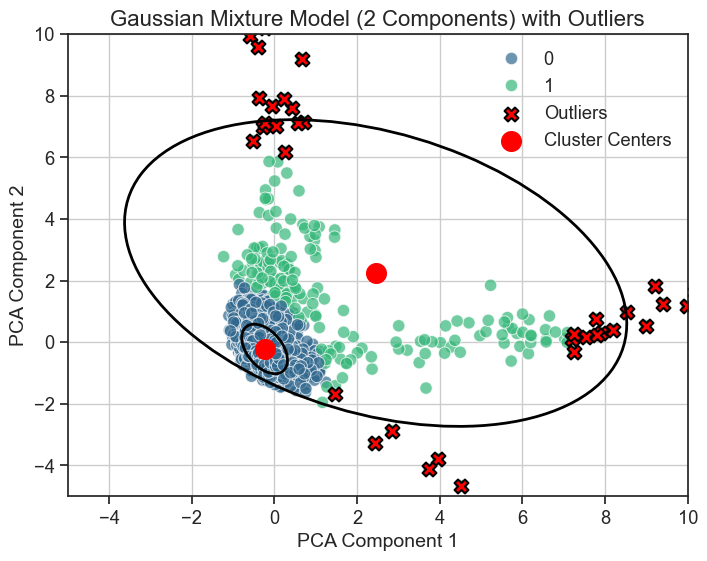

In [46]:
# just for visualization
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse

# Fit the Gaussian Mixture Model (2 components)
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(df_pca_2d)

# Get cluster assignments and probabilities
labels = gmm.predict(df_pca_2d)
probs = gmm.predict_proba(df_pca_2d)

# Calculate the log-likelihood of each data point
log_likelihoods = gmm.score_samples(df_pca_2d)

# Find the threshold for the bottom 5% log-likelihood values
threshold = np.percentile(log_likelihoods, 2)

# Identify outliers (bottom 5% of log-likelihood)
outlier_mask = log_likelihoods < threshold

# Plot the 2D data with clusters
plt.figure(figsize=(8, 6))

# Scatter plot with points that are not outliers
sns.scatterplot(x=df_pca_2d['PCA_Component_1'], y=df_pca_2d['PCA_Component_2'], hue=labels, palette='viridis', s=80, alpha=0.7)

# Scatter plot with outliers, use a distinct color (red)
sns.scatterplot(x=df_pca_2d['PCA_Component_1'][outlier_mask], 
                y=df_pca_2d['PCA_Component_2'][outlier_mask], 
                color='red', s=100, label='Outliers', edgecolor='black', linewidth=1.5, marker='X')

# Plot the GMM cluster centers with round markers
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='o', label='Cluster Centers')

# Add ellipses around each Gaussian
for i in range(n_components):
    # Get the covariance matrix for each component
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])  # The first 2 dimensions (PCA components)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)  # 2 standard deviations
    
    # Calculate the angle of the ellipse
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    ell = Ellipse(xy=centers[i], width=v[0], height=v[1], angle=angle, 
                  edgecolor='black', facecolor='none', linewidth=2)
    
    plt.gca().add_patch(ell)

# Customize plot
plt.title('Gaussian Mixture Model (2 Components) with Outliers', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)

# Set axis limits
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.legend()
plt.grid(True)

plt.show()

### working with labeled data

In [14]:
# export labeled data to csv
df_labeled_cleaned.to_csv('df_labeled.csv', index=False)

In [15]:
df_labeled_cleaned.head()

,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,id,Anomaly
0,-0.166153,-0.535664,-0.053124,0.616559,0.740373,-0.077557,0.970836,0.094530,0.491277,1,0
1,-0.322451,-0.452299,2.324045,1.135155,1.926234,-0.088211,3.009529,-0.473395,4.276621,1,0
2,-0.329009,-0.778510,0.697245,0.071023,1.358458,-0.023826,3.668501,-0.301769,6.083004,1,1
3,-0.253592,-0.731390,1.363573,0.639009,1.837115,-0.058103,2.218763,-0.025608,2.946397,1,0
4,-0.346496,-0.441425,2.155963,1.153115,0.812243,-0.073851,2.284661,-0.404745,3.445231,1,0


### Graph Anamoly Detection!

**Graph Construction**

In [1]:
import pandas as pd
df = pd.read_csv("Data/df_labeled.csv")
df.head()

,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,id,Anomaly
0,-0.166153,-0.535664,-0.053124,0.616559,0.740373,-0.077557,0.970836,0.094530,0.491277,1,0
1,-0.322451,-0.452299,2.324045,1.135155,1.926234,-0.088211,3.009529,-0.473395,4.276621,1,0
2,-0.329009,-0.778510,0.697245,0.071023,1.358458,-0.023826,3.668501,-0.301769,6.083004,1,1
3,-0.253592,-0.731390,1.363573,0.639009,1.837115,-0.058103,2.218763,-0.025608,2.946397,1,0
4,-0.346496,-0.441425,2.155963,1.153115,0.812243,-0.073851,2.284661,-0.404745,3.445231,1,0


In [6]:
import pandas as pd
import torch
from torch_geometric.data import Data

# Load your DataFrame
num_measurements = len(df)

# Step 1: Prepare features and labels
features = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']
X = torch.tensor(df[features].values, dtype=torch.float)  # Shape: [num_measurements, 9]
y = torch.tensor(df['Anomaly'].values, dtype=torch.long)  # Shape: [num_measurements]

# Step 2: Map measurements to stations
node_idx = torch.tensor(df['id'].values - 1, dtype=torch.long)  # Shape: [num_measurements]

# Step 3: Create edges
# Each measurement is a node, so node indices are 0 to num_measurements-1
edges = []

# Intra-station edges: Connect all measurements within the same station
for station in range(22):  # Stations 0 to 21 (0-based indexing)
    # Get indices of measurements for this station
    station_measurements = (node_idx == station).nonzero(as_tuple=True)[0]
    # Create a clique: connect each measurement to every other measurement in the same station
    for i in range(len(station_measurements)):
        for j in range(i + 1, len(station_measurements)):
            edges.append([station_measurements[i].item(), station_measurements[j].item()])
            edges.append([station_measurements[j].item(), station_measurements[i].item()])

# Inter-station edges: Connect measurements between consecutive stations
for station in range(21):  # Connect station i to i+1 (0 to 20 -> 1 to 21)
    measurements_station_i = (node_idx == station).nonzero(as_tuple=True)[0]
    measurements_station_j = (node_idx == station + 1).nonzero(as_tuple=True)[0]
    # Connect each measurement in station i to each measurement in station j
    for i in measurements_station_i:
        for j in measurements_station_j:
            edges.append([i.item(), j.item()])

# Convert edges to edge_index format
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]

# Step 4: Create Data object
data = Data(x=X, edge_index=edge_index, y=y, node_idx=node_idx)

# Step 5: Save to .pth file
torch.save(data, 'river_graph_measurements_as_nodes.pth')

In [9]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the GNN model
class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, input_dim=9, hidden_dim=16, num_classes=2):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, node_idx = data.x, data.edge_index, data.node_idx
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, node_idx)  # Shape: [num_stations, hidden_dim]
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Load the data
data = torch.load('river_graph_measurements_as_nodes.pth')

# Prepare ground truth labels (majority voting per station)
station_labels = torch.zeros(22, dtype=torch.long)  # One label per station
for station in range(22):
    station_measurements = (data.node_idx == station).nonzero(as_tuple=True)[0]
    station_y = data.y[station_measurements]
    station_labels[station] = 1 if station_y.float().mean() >= 0.5 else 0

# Initialize the model and optimizer
model = GNNNodeClassifier(input_dim=9, hidden_dim=16, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
print("Training the GNN Model...")
for epoch in range(100):
    model.train()  # Set to training mode
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, station_labels)  # Loss on station-level labels
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_gnn_model.pth')
print("\nModel training completed and saved to 'trained_gnn_model.pth'.\n")

# Evaluate the model
print("Evaluating Model Performance...")
model.eval()  # Set to evaluation mode
with torch.no_grad():
    output = model(data)  # Shape: [22, 2] (log probabilities for each station)
    predictions = torch.argmax(output, dim=1)  # Shape: [22] (predicted labels: 0 or 1)

# Compute performance metrics
predictions_np = predictions.cpu().numpy()
ground_truth_np = station_labels.cpu().numpy()

accuracy = accuracy_score(ground_truth_np, predictions_np)
precision = precision_score(ground_truth_np, predictions_np, zero_division=0)
recall = recall_score(ground_truth_np, predictions_np, zero_division=0)
f1 = f1_score(ground_truth_np, predictions_np, zero_division=0)
conf_matrix = confusion_matrix(ground_truth_np, predictions_np)

# Print evaluation results
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("(Rows: True labels, Columns: Predicted labels)")
print("[[True Negatives, False Positives], [False Negatives, True Positives]]")
print("\nStation Predictions vs Ground Truth:")
for station in range(22):
    print(f"Station {station + 1}: Predicted={'Anomalous' if predictions_np[station] == 1 else 'Non-Anomalous'}, "
          f"Ground Truth={'Anomalous' if ground_truth_np[station] == 1 else 'Non-Anomalous'}")

Training the GNN Model...
Epoch 0, Loss: 0.7250
Epoch 10, Loss: 0.4371
Epoch 20, Loss: 0.1205
Epoch 30, Loss: 0.0608
Epoch 40, Loss: 0.0538
Epoch 50, Loss: 0.0483
Epoch 60, Loss: 0.0420
Epoch 70, Loss: 0.0339
Epoch 80, Loss: 0.0245
Epoch 90, Loss: 0.0156

Model training completed and saved to 'trained_gnn_model.pth'.

Evaluating Model Performance...

Performance Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Confusion Matrix:
[[21  0]
 [ 0  1]]
(Rows: True labels, Columns: Predicted labels)
[[True Negatives, False Positives], [False Negatives, True Positives]]

Station Predictions vs Ground Truth:
Station 1: Predicted=Anomalous, Ground Truth=Anomalous
Station 2: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 3: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 4: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 5: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 6: Predicted=Non-Anomalous, Ground Truth=Non-Anoma

#### we can notice the model is overfitting to non anomlous since we have limited amount of anomalies, hence the graph anomlay semi supervised model

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.utils import subgraph
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

# ------------------------------
# Step 1: Load the full dataset
# ------------------------------
# Loads the graph data containing all measurements (nodes), edges, and labels from a saved file
data = torch.load('river_graph_measurements_as_nodes.pth')

# ------------------------------
# Step 2: Filter non-anomalous measurements for training
# ------------------------------
# Selects only non-anomalous measurements (labeled as 0) to train the model
non_anomalous_mask = (data.y == 0)  # Assuming 0 is non-anomalous
non_anomalous_x = data.x[non_anomalous_mask]
non_anomalous_node_idx = data.node_idx[non_anomalous_mask]
# Creates a subgraph with only non-anomalous nodes and their edges
edge_index, _ = subgraph(non_anomalous_mask, data.edge_index, relabel_nodes=True)
non_anomalous_data = Data(x=non_anomalous_x, edge_index=edge_index, node_idx=non_anomalous_node_idx)

# ------------------------------
# Step 3: Define the GNN Autoencoder model
# ------------------------------
# Defines a GNN-based autoencoder with two encoder layers and one decoder layer
class GNNAnomalyDetector(torch.nn.Module):
    def __init__(self, input_dim=9, hidden_dim=16):
        super(GNNAnomalyDetector, self).__init__()
        # Encoder: Two GCN layers to learn node representations
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # Decoder: Linear layer to reconstruct original features
        self.decoder = torch.nn.Linear(hidden_dim, input_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Encode through GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        # Decode to reconstruct input features
        x_recon = self.decoder(x)
        return x_recon

# Initialize the model and optimizer
model = GNNAnomalyDetector(input_dim=9, hidden_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# ------------------------------
# Step 4: Train the model on non-anomalous data
# ------------------------------
# Trains the model to reconstruct non-anomalous data using Mean Absolute Error (MAE)
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    x_recon = model(non_anomalous_data)
    loss = torch.mean(torch.abs(non_anomalous_data.x - x_recon))  # MAE loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Save the trained model for later use
torch.save(model.state_dict(), 'anomaly_detector.pth')


Epoch 0, Loss: 0.3854
Epoch 10, Loss: 0.3079
Epoch 20, Loss: 0.2916
Epoch 30, Loss: 0.2872
Epoch 40, Loss: 0.2850
Epoch 50, Loss: 0.2834
Epoch 60, Loss: 0.2823
Epoch 70, Loss: 0.2812
Epoch 80, Loss: 0.2801
Epoch 90, Loss: 0.2794


In [11]:
# ------------------------------
# Step 5: Compute reconstruction errors on the full dataset
# ------------------------------
# Evaluates the trained model on the full dataset to compute reconstruction errors
model.eval()
with torch.no_grad():
    full_recon = model(data)  # Reconstruct features for all nodes
    recon_errors = torch.mean(torch.abs(data.x - full_recon), dim=1)  # Per-node MAE

# ------------------------------
# Step 6: Aggregate errors per station
# ------------------------------
# Averages reconstruction errors for each station (assuming 22 stations)
station_errors = torch.zeros(22)
for station in range(22):
    mask = (data.node_idx == station)
    station_errors[station] = recon_errors[mask].mean()  # Mean error per station


In [12]:
# ------------------------------
# Step 7: Prepare ground truth station labels (majority voting)
# ------------------------------
# Determines station-level labels based on majority voting of measurement labels
station_labels = torch.zeros(22, dtype=torch.long)
for station in range(22):
    station_measurements = (data.node_idx == station).nonzero(as_tuple=True)[0]
    station_y = data.y[station_measurements]
    station_labels[station] = 1 if station_y.float().mean() >= 0.5 else 0  # Anomalous if mean >= 0.5

# ------------------------------
# Step 8: Tune the threshold for anomaly detection
# ------------------------------
# Finds the optimal threshold for classifying stations as anomalous by maximizing F1-score
thresholds = torch.linspace(station_errors.min(), station_errors.max(), 100)
best_threshold, best_f1 = 0, 0
for t in thresholds:
    preds = (station_errors > t).long()
    f1 = f1_score(station_labels.numpy(), preds.numpy())
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
print(f'\nBest Threshold: {best_threshold:.4f}, F1-Score: {best_f1:.4f}')



Best Threshold: 1.0536, F1-Score: 1.0000


In [13]:
# ------------------------------
# Step 9: Evaluate performance using the best threshold
# ------------------------------
# Classifies stations using the best threshold and computes performance metrics
test_preds = (station_errors > best_threshold).long()
test_labels = station_labels

# Compute evaluation metrics
accuracy = accuracy_score(test_labels.numpy(), test_preds.numpy())
precision = precision_score(test_labels.numpy(), test_preds.numpy(), zero_division=0)
recall = recall_score(test_labels.numpy(), test_preds.numpy(), zero_division=0)
f1 = f1_score(test_labels.numpy(), test_preds.numpy(), zero_division=0)
conf_matrix = confusion_matrix(test_labels.numpy(), test_preds.numpy())

# Print evaluation results
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("(Rows: True labels, Columns: Predicted labels)")
print("[[True Negatives, False Positives], [False Negatives, True Positives]]")

# Print station-level predictions and ground truth
print("\nStation Predictions vs Ground Truth:")
for station in range(22):
    print(f"Station {station + 1}: Predicted={'Anomalous' if test_preds[station] == 1 else 'Non-Anomalous'}, "
          f"Ground Truth={'Anomalous' if test_labels[station] == 1 else 'Non-Anomalous'}")


Performance Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Confusion Matrix:
[[21  0]
 [ 0  1]]
(Rows: True labels, Columns: Predicted labels)
[[True Negatives, False Positives], [False Negatives, True Positives]]

Station Predictions vs Ground Truth:
Station 1: Predicted=Anomalous, Ground Truth=Anomalous
Station 2: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 3: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 4: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 5: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 6: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 7: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 8: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 9: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 10: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 11: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
Station 12: Predicted=Non-Anom

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import subgraph
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

# ------------------------------
# Step 1: Load the full dataset
# ------------------------------
data = torch.load('river_graph_measurements_as_nodes.pth')

# ------------------------------
# Step 2: Filter non-anomalous measurements for training
# ------------------------------
non_anomalous_mask = (data.y == 0)  # 0 is non-anomalous
non_anomalous_x = data.x[non_anomalous_mask]
non_anomalous_node_idx = data.node_idx[non_anomalous_mask]
edge_index, _ = subgraph(non_anomalous_mask, data.edge_index, relabel_nodes=True)
non_anomalous_data = Data(x=non_anomalous_x, edge_index=edge_index, node_idx=non_anomalous_node_idx)

# ------------------------------
# Step 3: Define the GNN Autoencoder model
# ------------------------------
class GNNAnomalyDetector(torch.nn.Module):
    def __init__(self, input_dim=9, hidden_dim=16):
        super(GNNAnomalyDetector, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.decoder = torch.nn.Linear(hidden_dim, input_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x_recon = self.decoder(x)
        return x_recon

# Initialize and train the model (assuming training is working fine)
model = GNNAnomalyDetector(input_dim=9, hidden_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    x_recon = model(non_anomalous_data)
    loss = torch.mean(torch.abs(non_anomalous_data.x - x_recon))  # MAE loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'anomaly_detector.pth')

# ------------------------------
# Step 4: Compute reconstruction errors on the full dataset
# ------------------------------
model.eval()
with torch.no_grad():
    full_recon = model(data)  # Reconstruct features for all nodes
    recon_errors = torch.mean(torch.abs(data.x - full_recon), dim=1)  # Per-measurement MAE

# ------------------------------
# Step 5: Tune the threshold for anomaly detection
# ------------------------------
thresholds = torch.linspace(recon_errors.min(), recon_errors.max(), 100)
best_threshold, best_f1 = 0, 0
for t in thresholds:
    preds = (recon_errors > t).long()
    f1 = f1_score(data.y.numpy(), preds.numpy())
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
print(f'\nBest Threshold: {best_threshold:.4f}, F1-Score: {best_f1:.4f}')

# ------------------------------
# Step 6: Classify measurements and evaluate performance
# ------------------------------
test_preds = (recon_errors > best_threshold).long()
test_labels = data.y  # Measurement-level labels

# Compute overall measurement-level metrics
accuracy = accuracy_score(test_labels.numpy(), test_preds.numpy())
precision = precision_score(test_labels.numpy(), test_preds.numpy(), zero_division=0)
recall = recall_score(test_labels.numpy(), test_preds.numpy(), zero_division=0)
f1 = f1_score(test_labels.numpy(), test_preds.numpy())
conf_matrix = confusion_matrix(test_labels.numpy(), test_preds.numpy())

# Print overall performance
print("\nOverall Measurement-Level Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("(Rows: True labels, Columns: Predicted labels)")
print("[[True Negatives, False Positives], [False Negatives, True Positives]]")

# ------------------------------
# Step 7: Per-Station Predictions and Summary
# ------------------------------
print("\nPer-Station Measurement Predictions:")
for station in range(22):  # 22 stations
    station_mask = (data.node_idx == station)
    station_preds = test_preds[station_mask]
    station_labels = test_labels[station_mask]
    num_measurements = station_mask.sum().item()
    num_anomalies_pred = station_preds.sum().item()
    
    # Print station summary
    print(f"\nStation {station + 1}: {num_anomalies_pred} anomalies detected out of {num_measurements} measurements")
    
    # Print predictions and ground truth for each measurement
    for i, (pred, label) in enumerate(zip(station_preds, station_labels)):
        pred_str = 'Anomalous' if pred == 1 else 'Non-Anomalous'
        label_str = 'Anomalous' if label == 1 else 'Non-Anomalous'
        print(f"  Measurement {i + 1}: Predicted={pred_str}, Ground Truth={label_str}")

Epoch 0, Loss: 0.3914
Epoch 10, Loss: 0.3156
Epoch 20, Loss: 0.2944
Epoch 30, Loss: 0.2884
Epoch 40, Loss: 0.2849
Epoch 50, Loss: 0.2830
Epoch 60, Loss: 0.2817
Epoch 70, Loss: 0.2806
Epoch 80, Loss: 0.2798
Epoch 90, Loss: 0.2791

Best Threshold: 0.8391, F1-Score: 0.7929

Overall Measurement-Level Performance Metrics:
Accuracy: 0.9791
Precision: 0.7872
Recall: 0.7986
F1-Score: 0.7929

Confusion Matrix:
[[2607   30]
 [  28  111]]
(Rows: True labels, Columns: Predicted labels)
[[True Negatives, False Positives], [False Negatives, True Positives]]

Per-Station Measurement Predictions:

Station 1: 61 anomalies detected out of 76 measurements
  Measurement 1: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
  Measurement 2: Predicted=Anomalous, Ground Truth=Non-Anomalous
  Measurement 3: Predicted=Anomalous, Ground Truth=Anomalous
  Measurement 4: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
  Measurement 5: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
  Measurement 6: Predi

### testing different hyperparameters

In [62]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import subgraph
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

# ------------------------------
# Step 1: Load the full dataset
# ------------------------------
data = torch.load('river_graph_measurements_as_nodes.pth')

# ------------------------------
# Step 2: Filter non-anomalous measurements for training
# ------------------------------
non_anomalous_mask = (data.y == 0)  # 0 is non-anomalous
non_anomalous_x = data.x[non_anomalous_mask]
non_anomalous_node_idx = data.node_idx[non_anomalous_mask]
edge_index, _ = subgraph(non_anomalous_mask, data.edge_index, relabel_nodes=True)
non_anomalous_data = Data(x=non_anomalous_x, edge_index=edge_index, node_idx=non_anomalous_node_idx)

# ------------------------------
# Step 3: Define the GNN Autoencoder model
# ------------------------------
class GNNAnomalyDetector(torch.nn.Module):
    def __init__(self, input_dim=9, hidden_dim=16):
        super(GNNAnomalyDetector, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.decoder = torch.nn.Linear(hidden_dim, input_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x_recon = self.decoder(x)
        return x_recon

# Initialize and train the model (assuming training is working fine)
model = GNNAnomalyDetector(input_dim=9, hidden_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(120):
    optimizer.zero_grad()
    x_recon = model(non_anomalous_data)
    loss = torch.mean(torch.abs(non_anomalous_data.x - x_recon))  # MAE loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'anomaly_detector.pth')

# ------------------------------
# Step 4: Compute reconstruction errors on the full dataset
# ------------------------------
model.eval()
with torch.no_grad():
    full_recon = model(data)  # Reconstruct features for all nodes
    recon_errors = torch.mean(torch.abs(data.x - full_recon), dim=1)  # Per-measurement MAE

# ------------------------------
# Step 5: Tune the threshold for anomaly detection
# ------------------------------
thresholds = torch.linspace(recon_errors.min(), recon_errors.max(), 100)
best_threshold, best_f1 = 0, 0
for t in thresholds:
    preds = (recon_errors > t).long()
    f1 = f1_score(data.y.numpy(), preds.numpy())
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
print(f'\nBest Threshold: {best_threshold:.4f}, F1-Score: {best_f1:.4f}')

# ------------------------------
# Step 6: Classify measurements and evaluate performance
# ------------------------------
test_preds = (recon_errors > best_threshold).long()
test_labels = data.y  # Measurement-level labels

# Compute overall measurement-level metrics
accuracy = accuracy_score(test_labels.numpy(), test_preds.numpy())
precision = precision_score(test_labels.numpy(), test_preds.numpy(), zero_division=0)
recall = recall_score(test_labels.numpy(), test_preds.numpy(), zero_division=0)
f1 = f1_score(test_labels.numpy(), test_preds.numpy())
conf_matrix = confusion_matrix(test_labels.numpy(), test_preds.numpy())

# Print overall performance
print("\nOverall Measurement-Level Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("(Rows: True labels, Columns: Predicted labels)")
print("[[True Negatives, False Positives], [False Negatives, True Positives]]")

# ------------------------------
# Step 7: Per-Station Predictions and Summary
# ------------------------------
print("\nPer-Station Measurement Predictions:")
for station in range(22):  # 22 stations
    station_mask = (data.node_idx == station)
    station_preds = test_preds[station_mask]
    station_labels = test_labels[station_mask]
    num_measurements = station_mask.sum().item()
    num_anomalies_pred = station_preds.sum().item()
    
    # Print station summary
    print(f"\nStation {station + 1}: {num_anomalies_pred} anomalies detected out of {num_measurements} measurements")
    
    # Print predictions and ground truth for each measurement
    for i, (pred, label) in enumerate(zip(station_preds, station_labels)):
        pred_str = 'Anomalous' if pred == 1 else 'Non-Anomalous'
        label_str = 'Anomalous' if label == 1 else 'Non-Anomalous'
        print(f"  Measurement {i + 1}: Predicted={pred_str}, Ground Truth={label_str}")

Epoch 0, Loss: 0.4213
Epoch 10, Loss: 0.3164
Epoch 20, Loss: 0.2970
Epoch 30, Loss: 0.2907
Epoch 40, Loss: 0.2872
Epoch 50, Loss: 0.2851
Epoch 60, Loss: 0.2835
Epoch 70, Loss: 0.2826
Epoch 80, Loss: 0.2819
Epoch 90, Loss: 0.2814
Epoch 100, Loss: 0.2809
Epoch 110, Loss: 0.2806

Best Threshold: 0.8493, F1-Score: 0.7942

Overall Measurement-Level Performance Metrics:
Accuracy: 0.9795
Precision: 0.7971
Recall: 0.7914
F1-Score: 0.7942

Confusion Matrix:
[[2609   28]
 [  29  110]]
(Rows: True labels, Columns: Predicted labels)
[[True Negatives, False Positives], [False Negatives, True Positives]]

Per-Station Measurement Predictions:

Station 1: 66 anomalies detected out of 76 measurements
  Measurement 1: Predicted=Non-Anomalous, Ground Truth=Non-Anomalous
  Measurement 2: Predicted=Anomalous, Ground Truth=Non-Anomalous
  Measurement 3: Predicted=Anomalous, Ground Truth=Anomalous
  Measurement 4: Predicted=Anomalous, Ground Truth=Non-Anomalous
  Measurement 5: Predicted=Anomalous, Ground Tr

## just for visualization

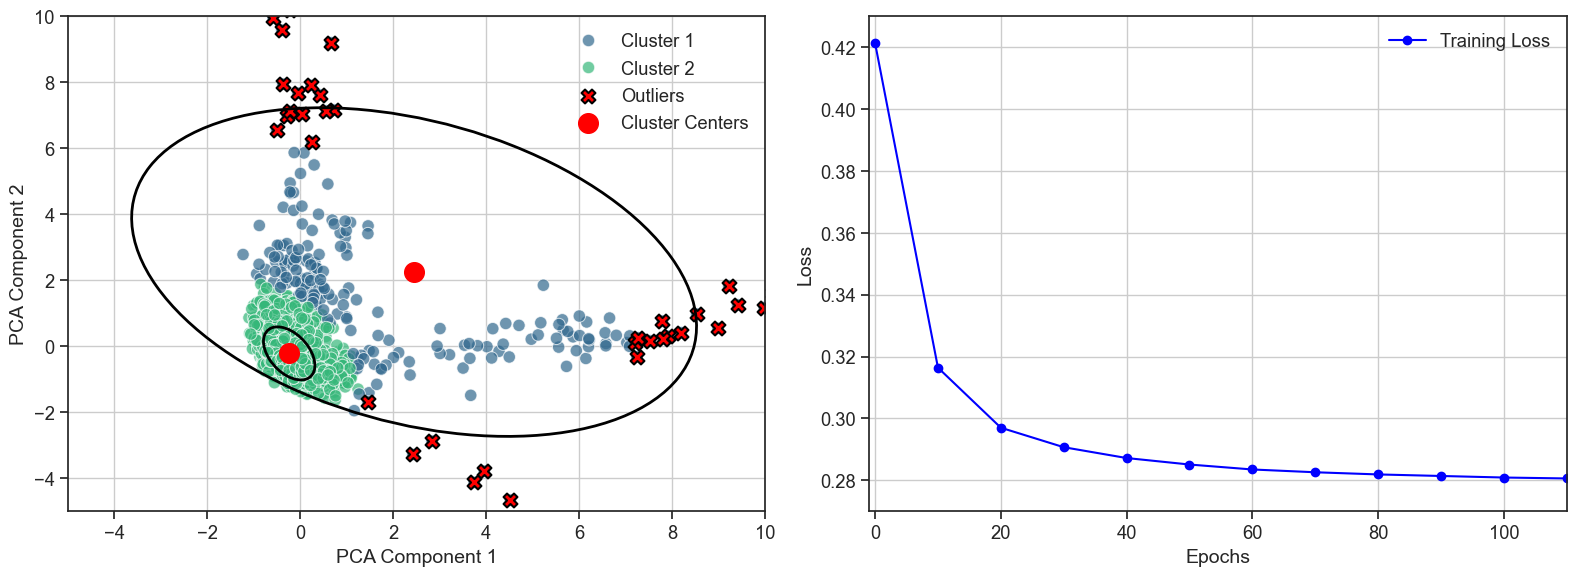

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# First Subplot Data (Loss over Epochs)
epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
losses = [0.4213, 0.3164, 0.2970, 0.2907, 0.2872, 0.2851, 0.2835, 0.2826, 0.2819, 0.2814, 0.2809, 0.2806]

# Set up subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the second subplot (GMM Clustering) on the left
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(df_pca_2d)

labels = gmm.predict(df_pca_2d)
log_likelihoods = gmm.score_samples(df_pca_2d)
threshold = np.percentile(log_likelihoods, 2)
outlier_mask = log_likelihoods < threshold

# Replace numerical labels with descriptive labels
label_names = ['Cluster 2' if label == 0 else 'Cluster 1' for label in labels]

sns.scatterplot(x=df_pca_2d['PCA_Component_1'], y=df_pca_2d['PCA_Component_2'], 
                hue=label_names, palette='viridis', s=80, alpha=0.7, ax=ax1)

sns.scatterplot(x=df_pca_2d['PCA_Component_1'][outlier_mask], 
                y=df_pca_2d['PCA_Component_2'][outlier_mask], 
                color='red', s=100, label='Outliers', edgecolor='black', linewidth=1.5, marker='X', ax=ax1)

centers = gmm.means_
ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='o', label='Cluster Centers')

for i in range(n_components):
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    ell = Ellipse(xy=centers[i], width=v[0], height=v[1], angle=angle, 
                  edgecolor='black', facecolor='none', linewidth=2)
    ax1.add_patch(ell)

#ax1.set_title('Gaussian Mixture Model (2 Components) with Outliers', fontsize=16)
ax1.set_xlabel('PCA Component 1', fontsize=14)
ax1.set_ylabel('PCA Component 2', fontsize=14)
ax1.set_xlim(-5, 10)
ax1.set_ylim(-5, 10)
ax1.legend()
ax1.grid(True)

# Plotting the first subplot (Loss vs. Epochs) on the right
ax2.plot(epochs, losses, marker='o', color='blue', label='Training Loss')
#ax2.set_title('Training Loss over Epochs', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.set_xlim(-0.9, 110)
ax2.set_ylim(0.27, 0.43)
ax2.grid(True)
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

/var/folders/4h/gs1k_4jd57q1qn2qphzx45l40000gn/T/ipykernel_2072/1424057043.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


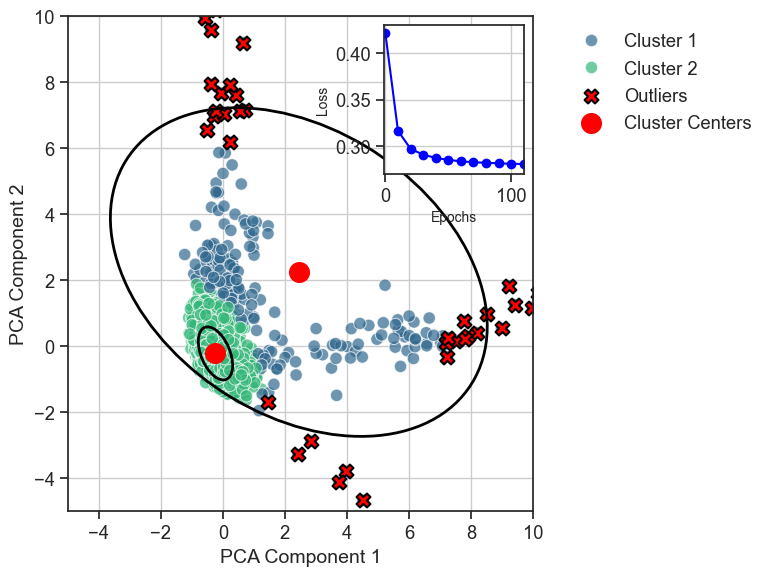

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data for the Training Loss Plot
epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
losses = [0.4213, 0.3164, 0.2970, 0.2907, 0.2872, 0.2851, 0.2835, 0.2826, 0.2819, 0.2814, 0.2809, 0.2806]

# Create a single figure with one axes object
fig, ax = plt.subplots(figsize=(8, 6))

# GMM Clustering on the main axes
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(df_pca_2d)

labels = gmm.predict(df_pca_2d)
log_likelihoods = gmm.score_samples(df_pca_2d)
threshold = np.percentile(log_likelihoods, 2)
outlier_mask = log_likelihoods < threshold

# Replace numerical labels with descriptive names
label_names = ['Cluster 2' if label == 0 else 'Cluster 1' for label in labels]

# Plot clusters
sns.scatterplot(x=df_pca_2d['PCA_Component_1'], y=df_pca_2d['PCA_Component_2'], 
                hue=label_names, palette='viridis', s=80, alpha=0.7, ax=ax)

# Plot outliers
sns.scatterplot(x=df_pca_2d['PCA_Component_1'][outlier_mask], 
                y=df_pca_2d['PCA_Component_2'][outlier_mask], 
                color='red', s=100, label='Outliers', edgecolor='black', linewidth=1.5, marker='X', ax=ax)

# Plot cluster centers
centers = gmm.means_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='o', label='Cluster Centers')

# Add covariance ellipses
for i in range(n_components):
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    ell = Ellipse(xy=centers[i], width=v[0], height=v[1], angle=angle, 
                  edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(ell)

# Configure main axes
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.grid(True)

# Create inset axes for the training loss plot
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper right')

# Plot training loss in the inset
inset_ax.plot(epochs, losses, marker='o', color='blue')
inset_ax.set_xlabel('Epochs', fontsize=10)
inset_ax.set_ylabel('Loss', fontsize=10)
inset_ax.grid(True)
inset_ax.set_xlim(-0.9, 110)
inset_ax.set_ylim(0.27, 0.43)

# Place the clustering legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout and display
plt.tight_layout()
plt.show()

/var/folders/4h/gs1k_4jd57q1qn2qphzx45l40000gn/T/ipykernel_2072/3958789217.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


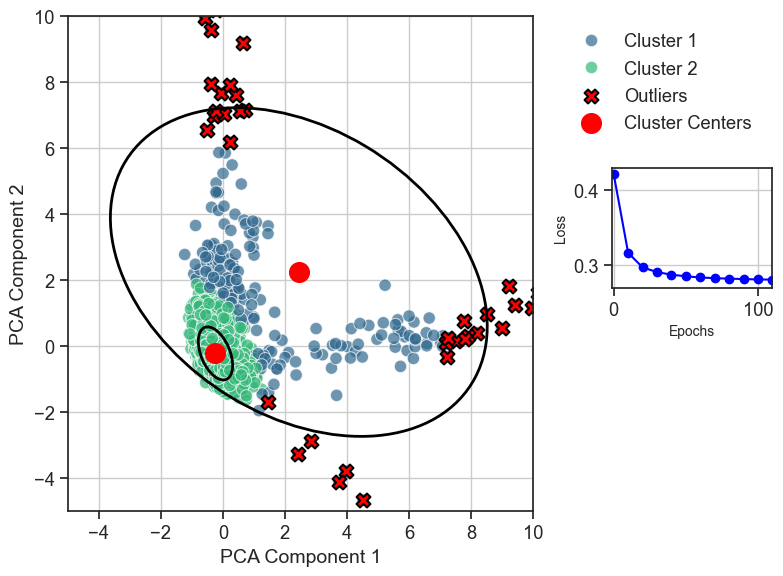

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data for the Training Loss Plot
epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
losses = [0.4213, 0.3164, 0.2970, 0.2907, 0.2872, 0.2851, 0.2835, 0.2826, 0.2819, 0.2814, 0.2809, 0.2806]

# Create a single figure with one axes object
fig, ax = plt.subplots(figsize=(8, 6))

# GMM Clustering on the main axes
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(df_pca_2d)

labels = gmm.predict(df_pca_2d)
log_likelihoods = gmm.score_samples(df_pca_2d)
threshold = np.percentile(log_likelihoods, 2)
outlier_mask = log_likelihoods < threshold

# Replace numerical labels with descriptive names
label_names = ['Cluster 2' if label == 0 else 'Cluster 1' for label in labels]

# Plot clusters
sns.scatterplot(x=df_pca_2d['PCA_Component_1'], y=df_pca_2d['PCA_Component_2'], 
                hue=label_names, palette='viridis', s=80, alpha=0.7, ax=ax)

# Plot outliers
sns.scatterplot(x=df_pca_2d['PCA_Component_1'][outlier_mask], 
                y=df_pca_2d['PCA_Component_2'][outlier_mask], 
                color='red', s=100, label='Outliers', edgecolor='black', linewidth=1.5, marker='X', ax=ax)

# Plot cluster centers
centers = gmm.means_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='o', label='Cluster Centers')

# Add covariance ellipses
for i in range(n_components):
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    ell = Ellipse(xy=centers[i], width=v[0], height=v[1], angle=angle, 
                  edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(ell)

# Configure main axes
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.grid(True)

# Create custom inset axes for the training loss plot and control its position
# Specify position [left, bottom, width, height] in normalized figure coordinates
inset_ax = fig.add_axes([0.78, 0.5, 0.2, 0.2])  # Adjust these values for more control

# Plot training loss in the inset
inset_ax.plot(epochs, losses, marker='o', color='blue')
inset_ax.set_xlabel('Epochs', fontsize=10)
inset_ax.set_ylabel('Loss', fontsize=10)
inset_ax.grid(True)
inset_ax.set_xlim(-0.9, 110)
inset_ax.set_ylim(0.27, 0.43)

# Place the clustering legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout and display
plt.tight_layout()
plt.show()


/var/folders/4h/gs1k_4jd57q1qn2qphzx45l40000gn/T/ipykernel_2072/3113354555.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


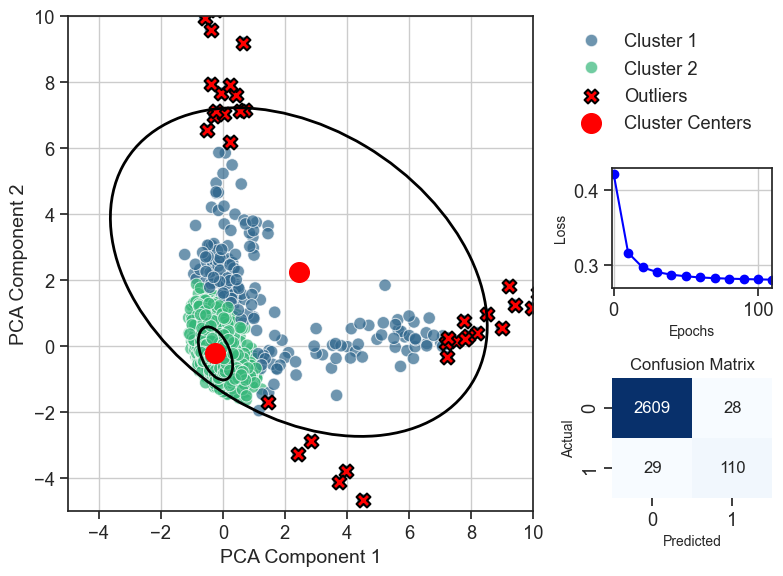

In [93]:
# combined efforts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data for the Training Loss Plot
epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
losses = [0.4213, 0.3164, 0.2970, 0.2907, 0.2872, 0.2851, 0.2835, 0.2826, 0.2819, 0.2814, 0.2809, 0.2806]

# Confusion Matrix
conf_matrix = np.array([[2609, 28], [29, 110]])

# Create a single figure with one axes object
fig, ax = plt.subplots(figsize=(8, 6))

# GMM Clustering on the main axes
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(df_pca_2d)

labels = gmm.predict(df_pca_2d)
log_likelihoods = gmm.score_samples(df_pca_2d)
threshold = np.percentile(log_likelihoods, 2)
outlier_mask = log_likelihoods < threshold

# Replace numerical labels with descriptive names
label_names = ['Cluster 2' if label == 0 else 'Cluster 1' for label in labels]

# Plot clusters
sns.scatterplot(x=df_pca_2d['PCA_Component_1'], y=df_pca_2d['PCA_Component_2'], 
                hue=label_names, palette='viridis', s=80, alpha=0.7, ax=ax)

# Plot outliers
sns.scatterplot(x=df_pca_2d['PCA_Component_1'][outlier_mask], 
                y=df_pca_2d['PCA_Component_2'][outlier_mask], 
                color='red', s=100, label='Outliers', edgecolor='black', linewidth=1.5, marker='X', ax=ax)

# Plot cluster centers
centers = gmm.means_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='o', label='Cluster Centers')

# Add covariance ellipses
for i in range(n_components):
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    ell = Ellipse(xy=centers[i], width=v[0], height=v[1], angle=angle, 
                  edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(ell)

# Configure main axes
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.grid(True)

# Create custom inset axes for the training loss plot and control its position
# Specify position [left, bottom, width, height] in normalized figure coordinates
inset_ax = fig.add_axes([0.78, 0.5, 0.2, 0.2])  # Adjust these values for more control

# Plot training loss in the inset
inset_ax.plot(epochs, losses, marker='o', color='blue')
inset_ax.set_xlabel('Epochs', fontsize=10)
inset_ax.set_ylabel('Loss', fontsize=10)
inset_ax.grid(True)
inset_ax.set_xlim(-0.9, 110)
inset_ax.set_ylim(0.27, 0.43)

# Create the third plot for the confusion matrix
# Specify position slightly lower than the loss plot (adjust [left, bottom, width, height])
conf_matrix_ax = fig.add_axes([0.78, 0.15, 0.2, 0.2])  # Position adjusted here

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1'], 
            yticklabels=['0', '1'], cbar=False, annot_kws={"size": 12}, ax=conf_matrix_ax)
conf_matrix_ax.set_xlabel('Predicted', fontsize=10)
conf_matrix_ax.set_ylabel('Actual', fontsize=10)
conf_matrix_ax.set_title('Confusion Matrix', fontsize=12)

# Place the clustering legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout and display
plt.tight_layout()
plt.show()

/var/folders/4h/gs1k_4jd57q1qn2qphzx45l40000gn/T/ipykernel_2072/2100947915.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


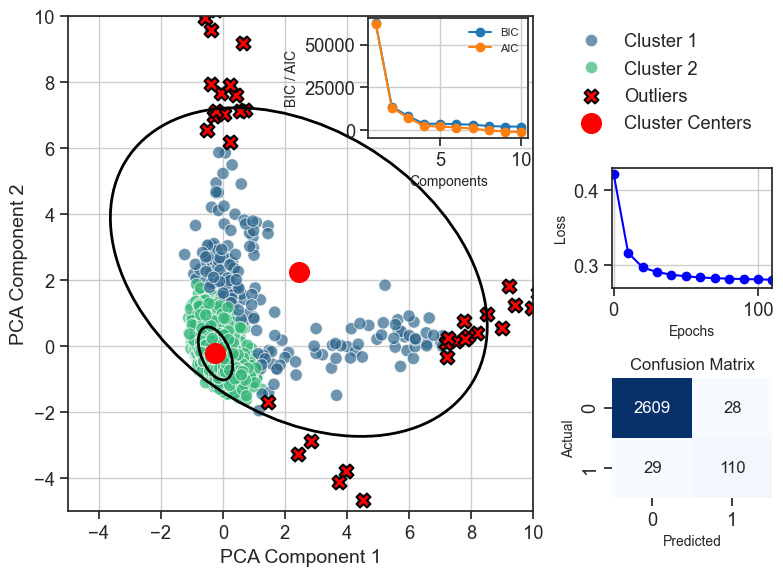

In [113]:
# combined efforts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data for the Training Loss Plot
epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
losses = [0.4213, 0.3164, 0.2970, 0.2907, 0.2872, 0.2851, 0.2835, 0.2826, 0.2819, 0.2814, 0.2809, 0.2806]

# Confusion Matrix
conf_matrix = np.array([[2609, 28], [29, 110]])

# GMM BIC and AIC Plot Data
df_for_gmm = df_scaled_cleaned.drop(columns=['id'])
component_range = range(1, 11)

bic_values = []
aic_values = []

# Loop over different number of components for BIC and AIC
for n_components in component_range:
    model = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    model.fit(df_for_gmm)
    bic_values.append(model.bic(df_for_gmm))
    aic_values.append(model.aic(df_for_gmm))

# Create a single figure with one axes object
fig, ax = plt.subplots(figsize=(8, 6))

# GMM Clustering on the main axes
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(df_pca_2d)

labels = gmm.predict(df_pca_2d)
log_likelihoods = gmm.score_samples(df_pca_2d)
threshold = np.percentile(log_likelihoods, 2)
outlier_mask = log_likelihoods < threshold

# Replace numerical labels with descriptive names
label_names = ['Cluster 2' if label == 0 else 'Cluster 1' for label in labels]

# Plot clusters
sns.scatterplot(x=df_pca_2d['PCA_Component_1'], y=df_pca_2d['PCA_Component_2'], 
                hue=label_names, palette='viridis', s=80, alpha=0.7, ax=ax)

# Plot outliers
sns.scatterplot(x=df_pca_2d['PCA_Component_1'][outlier_mask], 
                y=df_pca_2d['PCA_Component_2'][outlier_mask], 
                color='red', s=100, label='Outliers', edgecolor='black', linewidth=1.5, marker='X', ax=ax)

# Plot cluster centers
centers = gmm.means_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='o', label='Cluster Centers')

# Add covariance ellipses
for i in range(n_components):
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    ell = Ellipse(xy=centers[i], width=v[0], height=v[1], angle=angle, 
                  edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(ell)

# Configure main axes
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.grid(True)

# Create custom inset axes for the training loss plot
inset_ax = fig.add_axes([0.78, 0.5, 0.2, 0.2])  # Adjust these values for more control
inset_ax.plot(epochs, losses, marker='o', color='blue')
inset_ax.set_xlabel('Epochs', fontsize=10)
inset_ax.set_ylabel('Loss', fontsize=10)
inset_ax.grid(True)
inset_ax.set_xlim(-0.9, 110)
inset_ax.set_ylim(0.27, 0.43)

# Create the third plot for the confusion matrix
conf_matrix_ax = fig.add_axes([0.78, 0.15, 0.2, 0.2])  # Position adjusted here
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1'], 
            yticklabels=['0', '1'], cbar=False, annot_kws={"size": 12}, ax=conf_matrix_ax)
conf_matrix_ax.set_xlabel('Predicted', fontsize=10)
conf_matrix_ax.set_ylabel('Actual', fontsize=10)
conf_matrix_ax.set_title('Confusion Matrix', fontsize=12)

# Add the BIC and AIC plot as another inset plot
bic_aic_ax = fig.add_axes([0.475, 0.75, 0.2, 0.2])  # Random position for the BIC/AIC plot
bic_aic_ax.plot(component_range, bic_values, label='BIC', marker='o')
bic_aic_ax.plot(component_range, aic_values, label='AIC', marker='o')
bic_aic_ax.set_xlabel('Components', fontsize=10)
bic_aic_ax.set_ylabel('BIC / AIC', fontsize=10)
bic_aic_ax.legend(fontsize=8)
bic_aic_ax.grid(True)

# Place the clustering legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout and display
plt.tight_layout()
#plt.suptitle('GMM Clustering, Training Loss, Confusion Matrix, and BIC/AIC Comparison', fontsize=16, fontweight='bold')
plt.show()

/var/folders/4h/gs1k_4jd57q1qn2qphzx45l40000gn/T/ipykernel_2072/3560142096.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


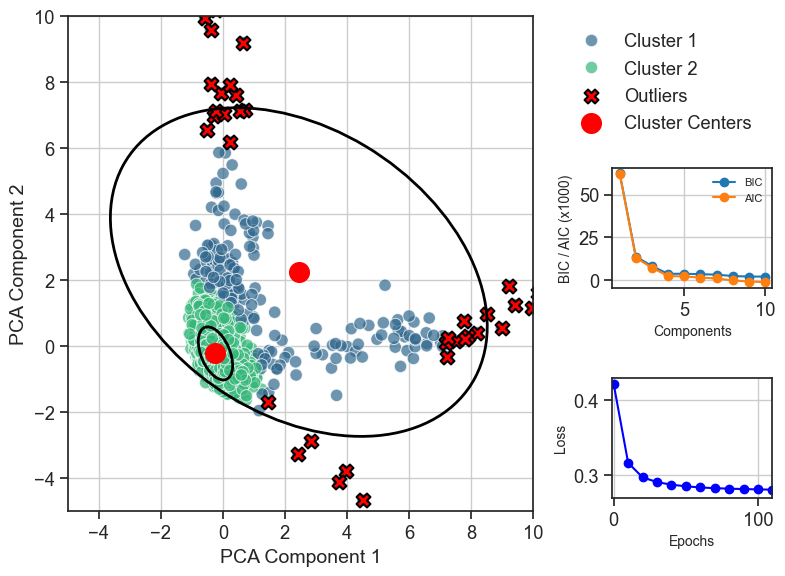

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data for the Training Loss Plot
epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
losses = [0.4213, 0.3164, 0.2970, 0.2907, 0.2872, 0.2851, 0.2835, 0.2826, 0.2819, 0.2814, 0.2809, 0.2806]

# Confusion Matrix
conf_matrix = np.array([[2609, 28], [29, 110]])

# GMM BIC and AIC Plot Data
df_for_gmm = df_scaled_cleaned.drop(columns=['id'])
component_range = range(1, 11)

bic_values = []
aic_values = []

# Loop over different number of components for BIC and AIC
for n_components in component_range:
    model = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    model.fit(df_for_gmm)
    bic_values.append(model.bic(df_for_gmm))
    aic_values.append(model.aic(df_for_gmm))

# Create a single figure with one axes object
fig, ax = plt.subplots(figsize=(8, 6))

# GMM Clustering on the main axes
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(df_pca_2d)

labels = gmm.predict(df_pca_2d)
log_likelihoods = gmm.score_samples(df_pca_2d)
threshold = np.percentile(log_likelihoods, 2)
outlier_mask = log_likelihoods < threshold

# Replace numerical labels with descriptive names
label_names = ['Cluster 2' if label == 0 else 'Cluster 1' for label in labels]

# Plot clusters
sns.scatterplot(x=df_pca_2d['PCA_Component_1'], y=df_pca_2d['PCA_Component_2'], 
                hue=label_names, palette='viridis', s=80, alpha=0.7, ax=ax)

# Plot outliers
sns.scatterplot(x=df_pca_2d['PCA_Component_1'][outlier_mask], 
                y=df_pca_2d['PCA_Component_2'][outlier_mask], 
                color='red', s=100, label='Outliers', edgecolor='black', linewidth=1.5, marker='X', ax=ax)

# Plot cluster centers
centers = gmm.means_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='o', label='Cluster Centers')

# Add covariance ellipses
for i in range(n_components):
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    ell = Ellipse(xy=centers[i], width=v[0], height=v[1], angle=angle, 
                  edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(ell)

# Configure main axes
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.grid(True)

# Create custom inset axes for the training loss plot
inset_ax = fig.add_axes([0.78, 0.15, 0.2, 0.2])  # Adjust these values for more control
inset_ax.plot(epochs, losses, marker='o', color='blue')
inset_ax.set_xlabel('Epochs', fontsize=10)
inset_ax.set_ylabel('Loss', fontsize=10)
inset_ax.grid(True)
inset_ax.set_xlim(-0.9, 110)
inset_ax.set_ylim(0.27, 0.43)

# Add the BIC and AIC plot as another inset plot
bic_aic_ax = fig.add_axes([0.78, 0.5, 0.2, 0.2])  # Random position for the BIC/AIC plot
bic_aic_ax.plot(component_range, np.array(bic_values) / 1000, label='BIC', marker='o')
bic_aic_ax.plot(component_range, np.array(aic_values) / 1000, label='AIC', marker='o')
bic_aic_ax.set_xlabel('Components', fontsize=10)
bic_aic_ax.set_ylabel('BIC / AIC (x1000)', fontsize=10)
bic_aic_ax.legend(fontsize=8)
bic_aic_ax.grid(True)

# Place the clustering legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout and display
plt.tight_layout()
#plt.suptitle('GMM Clustering, Training Loss, Confusion Matrix, and BIC/AIC Comparison', fontsize=16, fontweight='bold')
plt.show()

# The end